# Telco Churn Analysis and Retention Offer Optimization (Rule-based)

## Introduction

Some definitions that may be useful:
- Churn - when customers cancel subscriptions, causing revenue loss. 
- Retention discount - an incentive offered by a business to encourage a customer to continue their business.  
  
My goal for this project was to build a simple model that determines which customers we should offer retention discounts to in order to be profitable. In this notebook, we:  
1. Analyze churn patterns based on customer attributes  
2. Assign risk scores to customers using these attributes
3. Estimate expected value of offering a retention discount  
4. Evaluate expected value at different discount levels  
5. Recommend an optimal risk score threshold to offer retention discounts given an offer cost  

## Import libraries, functions

Functions are imported from main.py for better organization and readability.

In [13]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../code"))

from main import (
    convert_churn_to_numeric,
    plot_monthly_charges_distribution,
    churn_probability_by_charge_bucket,
    assign_risk_score,
    evaluate_risk_score,
    compute_expected_value,
    compute_cost_sensitivity,
    plot_ev_by_risk,
    generate_recommendation_table,
)

## Load and clean data

TotalCharges column is stored as strings, with some blank columns. Then, convert to numeric and drop NaN.

In [14]:
df = pd.read_csv("../data/telco_churn.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(subset=["TotalCharges"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

## Convert churn to numeric

Map yes/no to 1/0. This allows for later steps that require mathematical operations, such as finding probabilities, rates, and expected value.

In [15]:
df = convert_churn_to_numeric(df)
#df[["Churn","ChurnFlag"]].head()
print(df[["Churn","ChurnFlag"]].head())

  Churn  ChurnFlag
0    No          0
1    No          0
2   Yes          1
3    No          0
4   Yes          1


## Find churn rate: overall, by monthly charges, and by contract type

This gives more information about customer churn trends throughout different attributes.

In [16]:
churn_rate = df["Churn"].value_counts(normalize=True)
print("Overall churn rate: ")
print(churn_rate)

monthly_churn = df.groupby("Churn")["MonthlyCharges"].mean()
print("\nAverage MonthlyCharges by Churn status: ")
print(monthly_churn)

contract_churn = df.groupby("Contract")["Churn"].value_counts(normalize=True).unstack()
print("\nChurn rate by Contract type: ")
print(contract_churn)

Overall churn rate: 
Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64

Average MonthlyCharges by Churn status: 
Churn
No     61.307408
Yes    74.441332
Name: MonthlyCharges, dtype: float64

Churn rate by Contract type: 
Churn                 No       Yes
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887228  0.112772
Two year        0.971513  0.028487


A churn rate of 26.6% is substantial for subscription businesses and typically warrants intervention (in this case, offering a retention discount). Additionally, observe that customers who churned had, on average, monthly charges about $13 higher than those who stayed. Lastly, notice that customers with month-to-month contracts have a significantly higher churn rate than those with two year contracts. These characteristics will be considered when assigning risk scores later.

## Plot monthly charges distribution, create monthly charge buckets

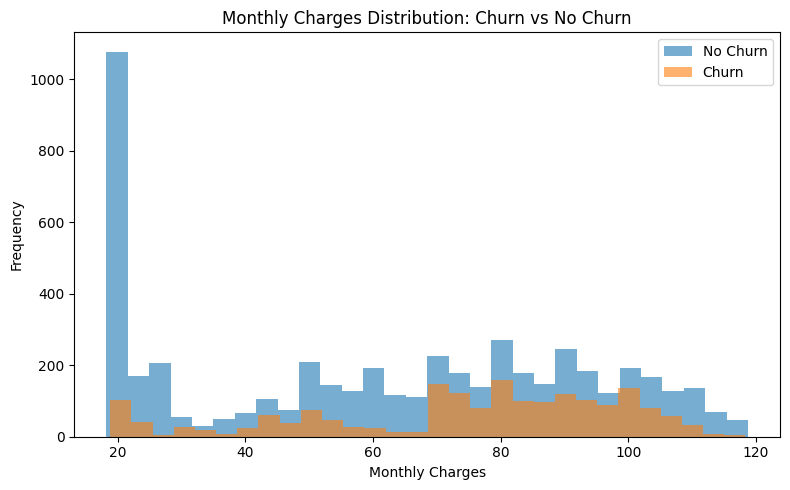

In [17]:
plot_monthly_charges_distribution(df)

Create low/medium/high charge buckets. From the histogram, observe clear breaks around 40 and 70. Then, these will be the cutoffs for buckets. Low: 0-40, Medium: 40-70, High: 70+

In [18]:
bucket_probs = churn_probability_by_charge_bucket(df)
print("Churn probability by monthly charge bucket:")
print(bucket_probs)

print("\n", df[["MonthlyCharges","ChargeBucket"]].head())

Churn probability by monthly charge bucket:
ChargeBucket
Low       0.116812
Medium    0.239654
High      0.353812
Name: ChurnFlag, dtype: float64

    MonthlyCharges ChargeBucket
0           29.85          Low
1           56.95       Medium
2           53.85       Medium
3           42.30       Medium
4           70.70         High


Customers with lower monthly charges are less likely to churn. This is consistent with the previously found Average MonthlyCharges by Churn status.

## Assign churn risk scores

Based on contract type and charge bucket, assign risk scores from 0-4. A higher risk score indicates higher risk of churn.

In [19]:
df = assign_risk_score(df)
print(df[["Contract","ChargeBucket","ContractRisk","ChargeRisk","RiskScore"]].head())

         Contract ChargeBucket  ContractRisk  ChargeRisk  RiskScore
0  Month-to-month          Low             2           0          2
1        One year       Medium             1           1          2
2  Month-to-month       Medium             2           1          3
3        One year       Medium             1           1          2
4  Month-to-month         High             2           2          4


Note that this is a simplified model, and risk scores 0-4 do not reflect all factors that determine churn.

## Validate risk score

Evaluate churn probability by risk score and verify that the data is consistent with predictions.

In [20]:
evaluate_risk_score(df)


Churn Probability by RiskScore: 
RiskScore
0    0.007564
1    0.027027
2    0.140267
3    0.275822
4    0.526943
Name: ChurnFlag, dtype: float64


As expected, customers with lower RiskScore are less likely to churn.

## Expected value at one offer cost

Find expected value (EV) at $15 offer cost. EV is (revenue saved) - (offer cost), which is calculated as (probability of churn) * (monthly charge) - (offer cost). $15 is chosen as an example offer cost that is realistic and consistent with real world retention discounts. Then, an EV greater than 0 means that offering a retention discount is profitable, because revenue saved > offer cost.

In [21]:
compute_expected_value(df, offer_cost=15)



Expected Value Table
           Churn Probability  Average Monthly Charge  Expected Value
RiskScore                                                           
0                   0.007564               22.426551      -14.830359
1                   0.027027               36.320120      -14.018375
2                   0.140267               58.867840       -6.742804
3                   0.275822               70.828534        4.536087
4                   0.526943               87.517787       31.116907


Observe that risk score levels 3 and 4 have EV > 0. This means that offering a retention discount to customers with these risk scores would be profitable when the offer cost is $15.

## Cost sensitivity analysis

Find expected value with varying offer costs.

In [22]:
cost_list = [5, 10, 15, 20, 25]
compute_cost_sensitivity(df, cost_list)
#cost_sensitivity_df.head(10)


Cost Sensitivity Table
    OfferCost  RiskScore  ChurnProb  AvgMonthlyCharge  ExpectedValue
0           5          0   0.007564         22.426551      -4.830359
1           5          1   0.027027         36.320120      -4.018375
2           5          2   0.140267         58.867840       3.257196
3           5          3   0.275822         70.828534      14.536087
4           5          4   0.526943         87.517787      41.116907
5          10          0   0.007564         22.426551      -9.830359
6          10          1   0.027027         36.320120      -9.018375
7          10          2   0.140267         58.867840      -1.742804
8          10          3   0.275822         70.828534       9.536087
9          10          4   0.526943         87.517787      36.116907
10         15          0   0.007564         22.426551     -14.830359
11         15          1   0.027027         36.320120     -14.018375
12         15          2   0.140267         58.867840      -6.742804
13        

Observe that as offer cost rises, intervention becomes profitable only at higher risk scores. However, note that this project's purpose is not to determine the best offer cost, but rather to determine the best course of action when given an offer cost.

## EV vs RiskScore plot

Plot the relation between risk score and expected value at different offer costs.

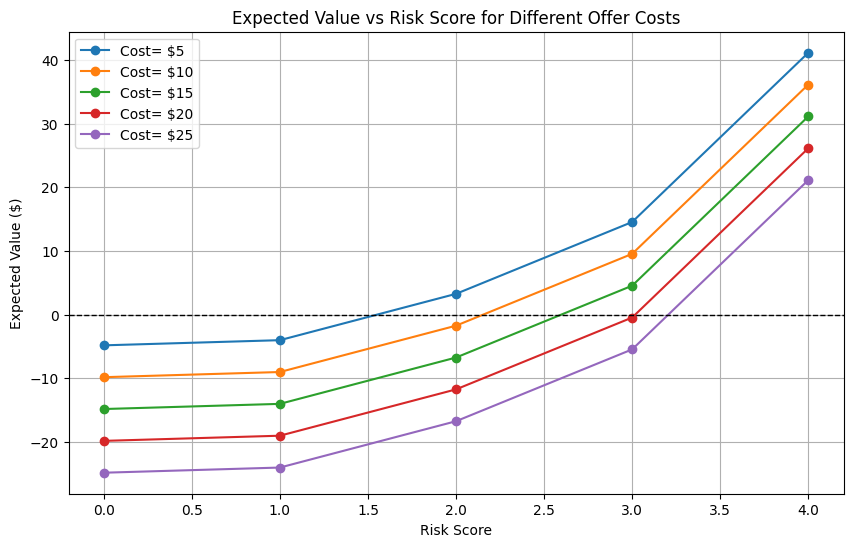

In [23]:
plot_ev_by_risk(df, cost_list)

Observe that intervention becomes increasingly profitable as risk scores increase, at any given offer cost.

## Final recommendation table

Given an offer cost, recommend the risk score threshold for which offering a retention discount would be profitable.

In [24]:
generate_recommendation_table(df, cost_list)


Recommendation Table
   OfferCost OptimalThreshold
0          5    RiskScore ≥ 2
1         10    RiskScore ≥ 3
2         15    RiskScore ≥ 3
3         20    RiskScore ≥ 4
4         25    RiskScore ≥ 4


Lower discounts allow intervention at more customers, while higher discounts only remain profitable at highest risk levels.